# Probabilistic Boolean Network Analysis Example
This notebook demonstrate how to run simulation on a Probabilistic Boolean Network (PBN) using BNMPy.

In [1]:
import sys
import numpy as np
sys.path.append('./src')
from BNMPy import BMatrix, PBN, vis
from BNMPy.steady_state import SteadyStateCalculator

## Load a PBN

The first step is to load a PBN.  
Similar to Boolean network, input file can be either a text file or a string containing the network definition, the format should look like this:  

- Each line has format: node = boolean_function, probability  
  
  - the boolean function part is defined as the same as Boolean network
  - The probability part can be omitted if there is only one function for that gene.
  - The boolean_function can also be a constant value (0 or 1), meaning that the gene is set as mutated/perturbed

In [2]:
# This is a simple PBN example from Shmulevich et al. 2002
network_string = """
x1 = (x1 | x2 | x3) & (!x1 | x2 | x3), 0.6
x1 = (x1 | x2 | x3) & (x1 | !x2 | !x3) & (!x1 | x2 | x3), 0.4
x2 = (x1 | x2 | x3) & (x1 | !x2 | !x3) & (!x1 | !x2 | x3)
x3 = (!x1 & x2 & x3) | (x1 & !x2 & x3) | (x1 & x2 & !x3) | (x1 & x2 & x3), 0.5
x3 = (x1 & x2 & x3), 0.5
"""
network = BMatrix.load_pbn_from_string(network_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 3 genes in the network.


In [10]:
# Optionally you can provide an initial state for later simulation
# This can be set in the next steps as well
initial_state = [1, 1, 0]
network = BMatrix.load_pbn_from_string(network_string, initial_state=initial_state)

PBN loaded successfully. There are 3 genes in the network.


We can also load a network from a txt file directly.

In [4]:
network_file = 'files/SimplePBN.txt'
network = BMatrix.load_pbn_from_file(network_file, initial_state=initial_state)

PBN loaded successfully. There are 3 genes in the network.


## Visualize the network

We can visualize the network using `vis.vis_network(network)`. It will show the network structure and color the nodes based on their in/out degrees.

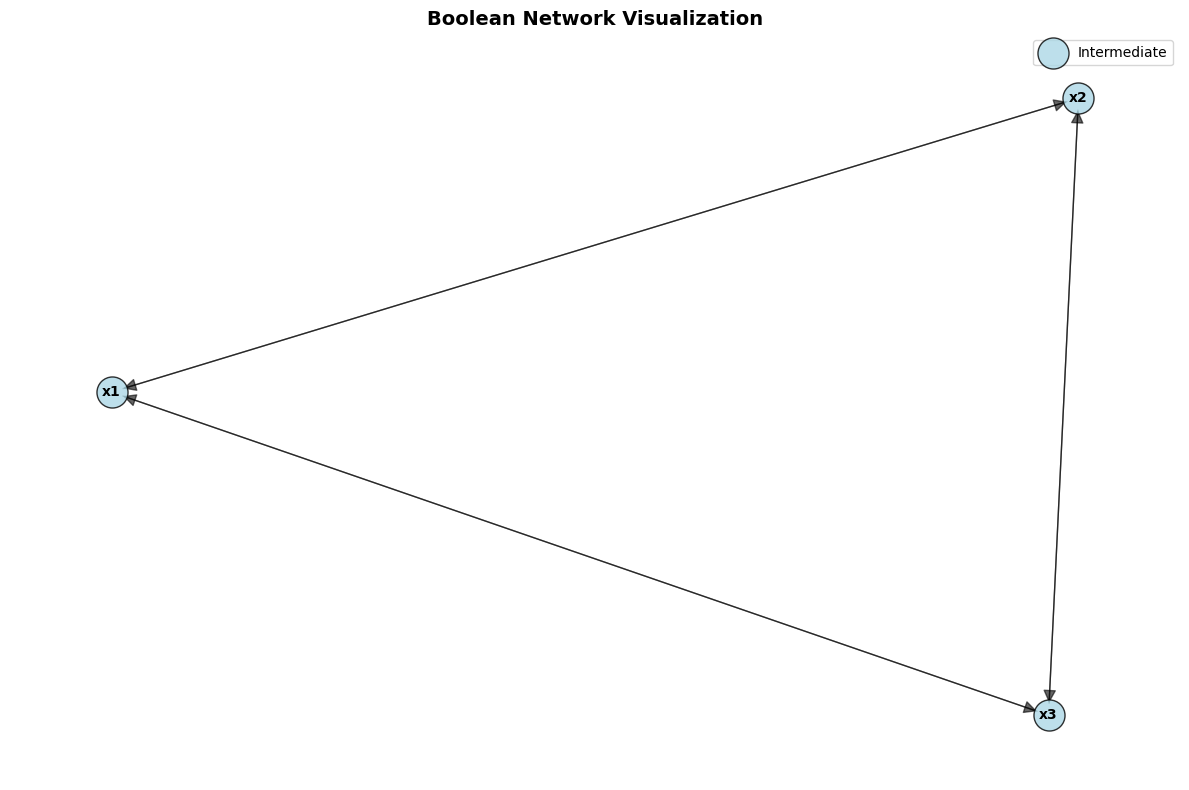

In [5]:
vis.vis_network(network)

For larger networks, you might want to see the network interactively.  
You can use the `interactive=True` option to save the network as an html file, and open it in your browser.  
The rules and probabilities of each node are shown when hovering over the node.

In [6]:
vis.vis_network(network, output_html="files/SimplePBN.html", interactive=True)

Network visualization saved to files/SimplePBN.html


## Update the network

BNMPy offers two ways to run simulation on a Probabilistic Boolean Network.
1. Update the network directly
2. Update the network with noise

### Direct update
Update the network directly.  
This will select a function for each node based on its probability distribution.
Then, update the network state based on the selected function.

In [11]:
np.random.seed(99) # for reproducibility

# simulate for 5 steps
network.update(5)

array([[1, 1, 0],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int8)

In [12]:
# we can set the initial states here
network.setInitialValues([1, 0, 1])
network.update(5)

array([[1, 0, 1],
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=int8)

In [14]:
# you can also set inital state for individual nodes
network.setInitialValue('x1', 0)
network.update(5)

array([[0, 1, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 1],
       [1, 1, 1]], dtype=int8)

### Update with noise

This method simulates the network's evolution over time with added noise.  
Noise randomly flips node states with probability p after normal network update, but is never applied to constant nodes (knockouts, see below).

In [15]:
np.random.seed(99) # for reproducibility

# set initial state
network.setInitialValues([0, 1, 1])
# using 10% noise
network.update_noise(p=0.1, iterations=10)

array([[0, 1, 1],
       [0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 1]], dtype=int8)

Note that the behavior of the network is different from the direct update even with the same initial state.

## Pertubations

BNMPy offers two function to perform pertubations on a PBN.

### Knockout
Similar to Boolean network, knockout will set a specific node to be permanently fixed to a given value.

In [17]:
# set node x1 to constant value 1
network.knockout('x1', 0)
network.setInitialValues([0, 1, 1])
network.update_noise(p=0.1, iterations=10)

array([[0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [0, 0, 1],
       [0, 1, 1],
       [0, 0, 0]], dtype=int8)

The knockout nodes are not affected by noise or direct update.

### Knockdown

In addtion, BNMPy also allows to perform knockdown on a node.  
This will set a specific node to be partially effective for experimental perturbation. E.g., when using a drug to inhibit a gene, the efficacy is the probability of the drug being effective.

In [20]:
# reset previous perturbation
network.undoKnockouts()

# set node x1 to be inhibited with 80% probability
network.knockdown('x1', 0, efficacy=0.8)
network.setInitialValues([0, 1, 1])
network.update(10)

array([[0, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [1, 0, 0],
       [1, 1, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int8)

## Steady state analysis

Next, we can compute the steady state of the network.  
Currently, BNMPy supports two methods for PBN steady state analysis.
1. Monte Carlo approach
2. Two-state Markov Chain (TSMC)

### Monte Carlo

This method performs steady-state calculation using multiple independent simulations, as similar to how we update the network.
It runs `n_runs` simulations for `n_steps` steps, and takes the mean across all runs and the second half of each trajectory.

**Parameters**:

- `n_runs` (int, default=10): Number of independent simulation runs
- `n_steps` (int, default=1000): Number of simulation steps per run
- `p_noise` (float, default=0.01): Noise probability for `update_noise()`

In [21]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='monte_carlo',n_runs=20,n_steps=10000,p_noise=0)
steady_state

array([0.19833033, 0.62119576, 0.07235553])

### Two-state Markov Chain (TSMC)

This method was introduced in 1992 by Raftery and Lewis, and Shmulevich et al. proposed its application to the analysis of PBNs in 2003 (https://doi.org/10.1002/cfg.342).   
  
Basically, the steady-state dynamics of biological processes can be modelled as discrete-time Markov chains (DTMCs). And TSMC estimates the probability of a subset of states in the DTMC. 

**Parameters**:

- `epsilon` (float, default=0.001): Range of transition probability (smaller = more accurate)
- `r` (float, default=0.025): Range of accuracy - most sensitive parameter (smaller = more accurate)
- `s` (float, default=0.95): Probability of accuracy (closer to 1 = more confident)
- `p_noise` (float, default=0): Noise probability for Monte Carlo method
- `p_mir` (float, default=0.001): Perturbation probability (Miranda-Parga scheme)
- `initial_nsteps` (int, default=1000): Initial number of simulation steps
- `max_iterations` (int, default=100): Maximum convergence iterations
- `freeze_constant` (bool, default=False): Freeze self-loop nodes (constant nodes)

In [22]:
calc = SteadyStateCalculator(network)
steady_state = calc.compute_steady_state(method='tsmc',r=0.01,initial_nsteps=1000,max_iterations=500,freeze_constant=True)
steady_state

array([0.20188319, 0.61220342, 0.07748465])

More examples are given in `examples/PBN_steady_state.ipynb`.  
For details of the algorithm, please refer to the original paper.

## Plot the simulation

In [23]:
# First, we simulate the network for 200000 steps
noise_level = 0.05 # noise
y = network.update_noise ( noise_level  , 200000) # simulation with noise

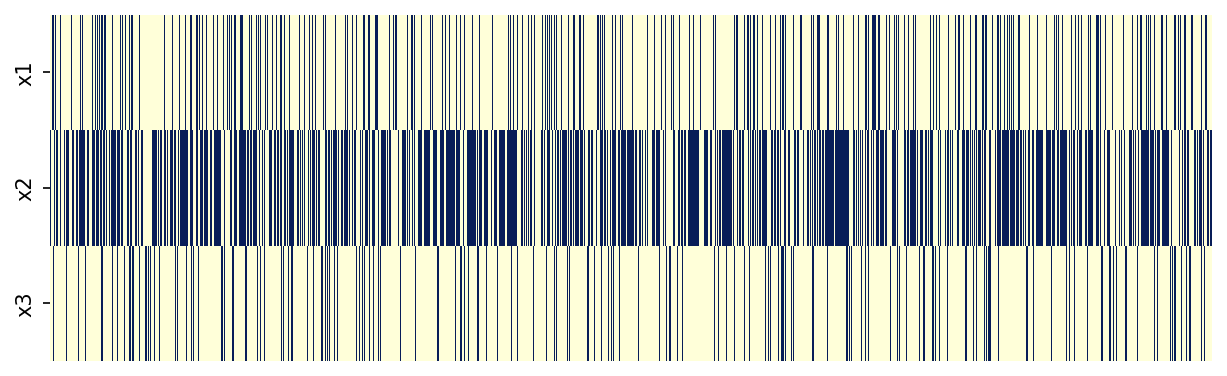

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot the simulation results
simulations = pd.DataFrame(y) 
simulations.columns = network.nodeDict.keys()
plt.figure(figsize=(10,3), dpi = 150)
# heapmap without clustering
sns.heatmap(simulations.transpose(), cmap="YlGnBu", cbar=False, xticklabels=False)
plt.show()

This heatmap shows the network states over 200000 steps.  
Next, we can look at how frequently the network will visit the dominant state as the simulation progress.

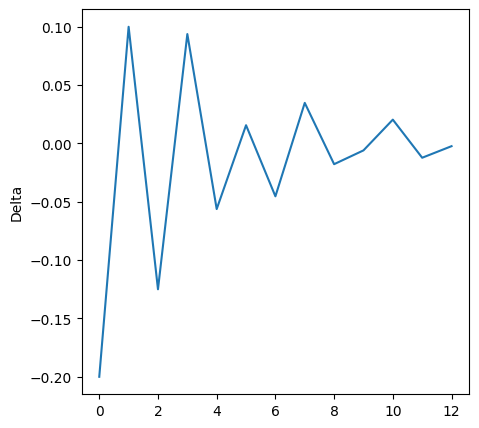

In [26]:
def count_state_frequency(simulations):
    """
    Compute the frequency of the most common state
    """
    dic_freq = {}
    for i in range(0,simulations.shape[0]):
        cur = simulations.iloc[i,:]
        cur = ','.join([str(x) for x in cur])
        if cur in dic_freq.keys():
            dic_freq[cur] += 1
        else:
            dic_freq[cur] = 1
    result = pd.DataFrame()
    state_list = []
    freq_list = []
    for key in dic_freq.keys():
        state_list.append(key)
        freq_list.append((dic_freq[key]/simulations.shape[0]))
    result['state'] = state_list
    result['freq'] = freq_list
    result.index = state_list
    result = result.drop(columns=['state'])
    return result.sort_values(by=['freq'],ascending=False)

all = pd.DataFrame()
delta = []
pre = count_state_frequency(simulations)

# exponentially growing windows
# e.g., 10, 20, 40, ..., up to 2^13 = 81920 steps
for i in range(0,14):
    cur = count_state_frequency(simulations.iloc[2**i*10:2**(i+1)*10,:])
    cur.columns = ["S"+str(i)]
    if i > 0:
        delta.append(cur.iloc[0,].values[0] - pre.iloc[0,].values[0])
    pre = cur
    all = pd.concat([all,cur],axis=1)

plt.figure(figsize=(5,5))
plt.ylabel("Delta")
plt.plot(delta)

Here each point measures the incremental gain or loss in the probability of the most frequently visited configuration when double the amount of data. Large positive or negative spikes mean that the distribution is shifting; zero indicate that the estimate is converging.

In this network the frequency oscillates until 10^8-step window (when delta becomes close to zero). The pattern suggests that after roughly 
10^4 updates the simulation has essentially settled.